# Assessing the role of the C parameter and learning it by nested cross-validation
#### _Author: Hugo SIMON_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn import image
from nilearn.plotting import plot_stat_map, show
%matplotlib inline

C:\Users\yugos\anaconda3\lib\site-packages\nilearn\input_data\__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Performing classification on Haxby dataset

In [2]:
haxby_dataset = datasets.fetch_haxby()
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions != 'rest'
conditions = conditions[condition_mask]
print(conditions.unique())
session = labels['chunks'][condition_mask]

Mask nifti image (3D) is located at: C:\Users\yugos/nilearn_data\haxby2001\mask.nii.gz
Functional nifti image (4D) is located at: C:\Users\yugos/nilearn_data\haxby2001\subj2\bold.nii.gz
['scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle' 'chair']


### Masking the data

In [3]:
mask_filename = haxby_dataset.mask
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
            standardize=True, memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0]
X = masker.fit_transform(func_filename)
X = X[condition_mask]
y = conditions.values
n_conditions = len(np.unique(y))

In [5]:
condition_ids = np.unique(conditions)
confusion = np.zeros((n_conditions, n_conditions))
for train, test in cv.split(X, y, session):
    y_pred = anova_svc.fit(X[train], y[train]).predict(X[test])
    for j, k in zip(y[test], y_pred):
        confusion[condition_ids == j, condition_ids == k] += 1

# confusion /= confusion.sum(0)
confusion /= confusion.sum()
print(f"Classification accuracy: {confusion.trace():.6f} / Chance level: {1/n_conditions}")

Classification accuracy: 0.590278 / Chance level: 0.125


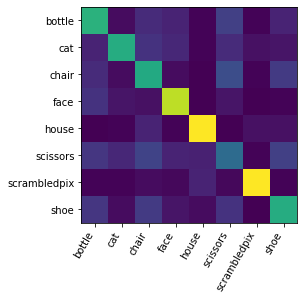

In [6]:
plt.figure()
ax = plt.subplot(111)
ax.imshow(confusion, interpolation='nearest')
plt.xticks(np.arange(n_conditions), condition_ids)
ax.set_xticklabels(condition_ids, rotation=60, ha='right')
plt.yticks(np.arange(n_conditions), condition_ids)
ax.set_position([.05, .15, .9, .75])
plt.show()

## Question 1: Explain the role of the C parameter.

$\hookrightarrow$ SVM stands for both "Machine à Vecteur de Support" and "Séparateur Vaste Marge", which are 2 separated components that describe the SVM classifier family. 
* "Machine à Vecteur de Support" describes the important notion of Kernel. The classifying function actually lives in the subset of an RKHS which is supported by the training points. 
* "Séparateur Vaste Marge" describes the notion of vast margin for the hinge loss, which induce a regularization term and allows for a kernelized dual problem. 

The C parameter is actually the inverse regularisation coefficient i.e. the total loss is $\frac 1 C$regularization loss + data fitting loss = $\frac 1 C$margin loss + hinge loss. The smaller the C, the smaller the inverse margin so the higher the margin, and vice-versa. If C is large, then the vast margin constraint becomes negligeable. 

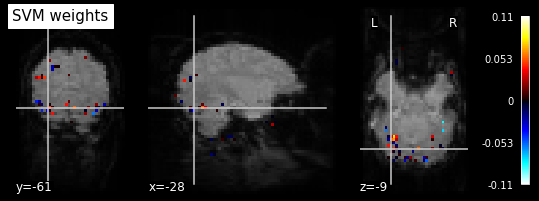

In [7]:
coef = feature_selection.inverse_transform(anova_svc.named_steps['svc'].coef_[:1])
weight_img = masker.inverse_transform(coef[0])
mean_img = image.mean_img(func_filename)
plot_stat_map(weight_img, mean_img, title='SVM weights')
weight_img.to_filename('haxby_face_vs_house.nii.gz')

## Question 2: What is the optimal value of C ? What is the optimal classification score ? Is it highly sensitive on the C parameter ?

In [18]:
clf = SVC(kernel='linear', C=None)
feature_selection = SelectKBest(f_classif, k=500)
anova_svc = Pipeline([('anova', feature_selection), ('svc', clf)])
cv = LeaveOneGroupOut()
print(f"number of splits: {len(np.unique(session))}")

Cs = np.logspace(-6, 6, 13)
cv_scoress = []
for i in range(len(Cs)):
    anova_svc.set_params(svc__C=Cs[i])
    cv_scores = cross_val_score(anova_svc, X, y, cv=cv.split(X, y, session), n_jobs=4)
    cv_scoress.append(cv_scores)

number of splits: 12


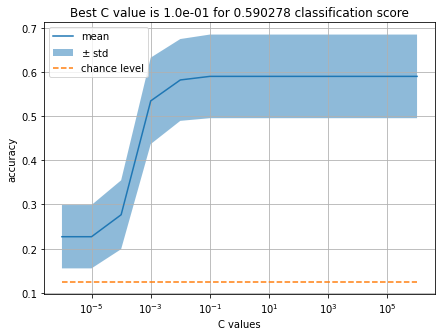

In [63]:
plt.figure(figsize=(7,5))
cv_means = np.mean(cv_scoress, axis=-1)
cv_std = np.std(cv_scoress, axis=-1)
plt.semilogx(Cs, cv_means, label="mean")
plt.fill_between(Cs, cv_means-cv_std, cv_means+cv_std, alpha=0.5, label="$\pm$ std")
plt.hlines(1/n_conditions, Cs.min(), Cs.max(), 'C1', linestyle="--", label="chance level")
plt.title(f"Best C value is {Cs[cv_means.argmax()]:.1e} for {cv_means.max():.6f} classification score")
plt.xlabel("C values"), plt.ylabel("accuracy")
plt.grid(), plt.legend(), plt.show();

$\hookrightarrow$ Classification is sensitive on the parameter $C$ to some extend. Between the value $10^{-6}$ and $10^{-1}$, cross-validation accuracy rises from about $0.23$ to $0.60$. However, accuracy remains constant for higher values of $C$. This means vast margin regularization doesn't play any roll after this threshold i.e. we optimize on the data fitting term only.

## Question 3: Explain the principle of nested cross-validation. 
$\hookrightarrow$ Nested cross-validation is an approach to model hyperparameter optimization and model selection that attempts to overcome the problem of overfitting the training dataset e.g. when tunning hyperparameters through grid search cross-validation. The procedure involves treating model hyperparameter optimization as part of the model itself and evaluating it within the broader k-fold cross-validation procedure. As such, the cross-validation procedure for model hyperparameter optimization is nested inside another cross-validation procedure for model selection.

## Question 4: Compare the results with different number of internal and external folds.

In [46]:
%%time
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
cv_kf3 = KFold(n_splits=3, shuffle=True)
cv_kf10 = KFold(n_splits=10, shuffle=True)
cv_logo = LeaveOneGroupOut().split(X, y, session)
cv_logo2 = LeaveOneGroupOut().split(X, y, session)
cvs = [[cv_kf3, cv_logo],[cv_kf10, cv_logo2],[cv_kf3, cv_kf3]]

nested_scores = []
for inner_cv, outer_cv in cvs:
    # Nested CV with parameter optimization
    gscv = GridSearchCV(estimator=anova_svc, param_grid={'svc__C':Cs}, cv=inner_cv, verbose=1)
    nested_score = cross_val_score(gscv, X=X, y=y, cv=outer_cv)
    nested_scores.append(nested_score)
    print()

Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits
Fitting 3 folds for each of 13 candidates, totalling 39 fits

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Fitting 10 folds for each of 13 candidates, totalling 130 fits
Fitting 10 folds for each of 13 candidates, totalling 130 fits
Fitting 10 folds for each of 13 candidates, totalling 130 fits
Fitting 10 fold

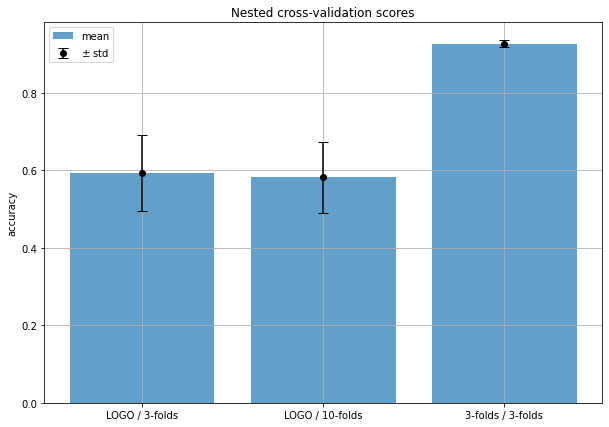

In [71]:
nested_scores_mean, nested_scores_std = [], []
for nested_score in nested_scores:
    nested_scores_mean.append(nested_score.mean())
    nested_scores_std.append(nested_score.std())

plt.figure(figsize=(10,7))
exps_name = ["LOGO / 3-folds", "LOGO / 10-folds", "3-folds / 3-folds"]
plt.bar(exps_name, nested_scores_mean, alpha=0.7, label="mean")
plt.errorbar(exps_name, nested_scores_mean, yerr=nested_scores_std, fmt="o", capsize=5, color="k", label="$\pm$ std")
plt.ylabel("accuracy"), plt.title("Nested cross-validation scores")
plt.legend(), plt.grid(), plt.show();

$\hookrightarrow$ The use of 3-folds instead of 10-folds for the inner cross-validation does not drasticaly change the nested cross-validation accuracy. However, using 3-folds instead of LeaveOneGroupOut defined by sessions leads to high cross-validation accuracy. This could mean some sessions can be highly different from each others, thus one can difficulty be infered by looking to others. By shuffling all data one have access to a more representative dataset and could yield higher accuracy. Nevertheless, in practice, we could have only access to some sessions to tune hyperparameters and predict others.